In [1]:
import pandas as pd
import altair as alt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
from altair.expr import datum
from altair_saver import save

alt.data_transformers.enable('data_server')
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('Boonsong Lekagul waterways readings.csv',parse_dates=['sample date'])
df.head()

,id,value,location,sample date,measure
0,2221,2.00,Boonsri,1998-01-11,Water temperature
1,2223,9.10,Boonsri,1998-01-11,Dissolved oxygen
2,2227,0.33,Boonsri,1998-01-11,Ammonium
3,2228,0.01,Boonsri,1998-01-11,Nitrites
4,2229,1.47,Boonsri,1998-01-11,Nitrates


In [3]:
df['year'] = df['sample date'].dt.year
df['month'] = df['sample date'].dt.month

In [4]:
df.head()

,id,value,location,sample date,measure,year,month
0,2221,2.00,Boonsri,1998-01-11,Water temperature,1998,1
1,2223,9.10,Boonsri,1998-01-11,Dissolved oxygen,1998,1
2,2227,0.33,Boonsri,1998-01-11,Ammonium,1998,1
3,2228,0.01,Boonsri,1998-01-11,Nitrites,1998,1
4,2229,1.47,Boonsri,1998-01-11,Nitrates,1998,1


In [5]:
print('Total unique measurements = ',df['measure'].nunique())
print('Total number of years = ',df['year'].nunique())
print('Total number of months = ',df['month'].nunique())

Total unique measurements =  106
Total number of years =  19
Total number of months =  12


In [6]:
df.describe().loc[['min', 'max'], ['year', 'month']]

,year,month
min,1998.0,1.0
max,2016.0,12.0


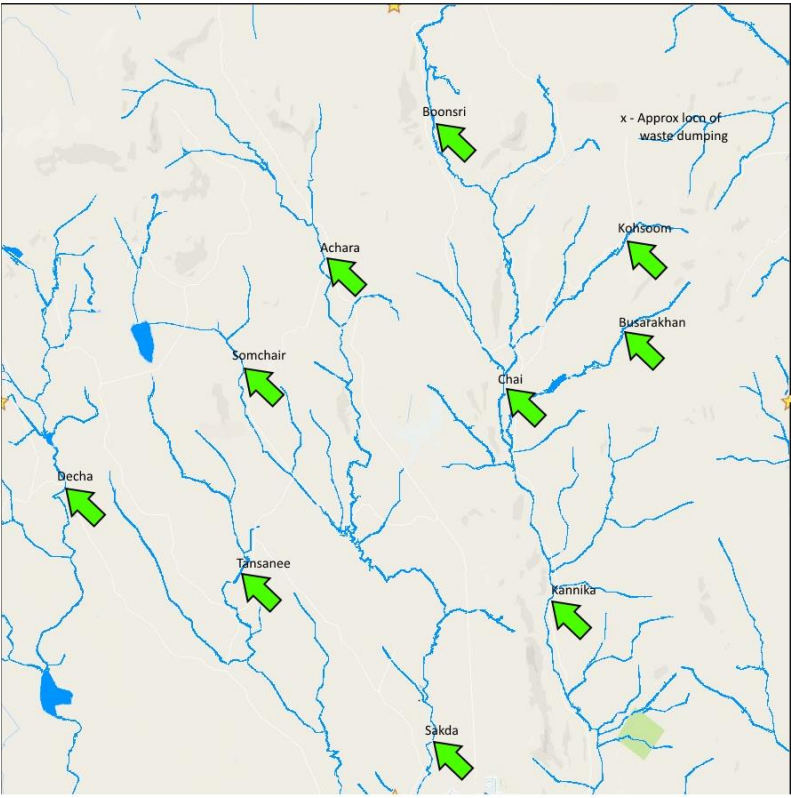

In [7]:
Image(filename='cst_4060_cw2_map.png', width=500)

Closest locations from dumping site were Bonoosri, Kohsoom and Busarakhan

## Q2(i) - Missing Data

In [8]:
# creating a pivot table in order to get nans for the values that are missing.
missing_data = df.pivot_table(values='value',index='measure',columns='year',aggfunc=np.mean)
missing_data.reset_index(inplace=True)

In [9]:
missing_data.head()

year,measure,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,"1,2,3-Trichlorobenzene",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001715,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"1,2,4-Trichlorobenzene",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001000,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AGOC-3A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.440274,2.923903,0.252466
3,AOX,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.757746,0.000,21.388372,NaN,NaN,25.875,NaN,NaN,17.900000
4,Acenaphthene,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004059,0.003,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Melting it into a format so that we retain the NaN's and we have 3 columns 1 measure, 2 year and 3 value. That can be used in
# a Heatmap.
temp_df = pd.melt(missing_data, id_vars=['measure'], value_vars=missing_data.columns[1:])

In [11]:
temp_df.head()

,measure,year,value
0,"1,2,3-Trichlorobenzene",1998,NaN
1,"1,2,4-Trichlorobenzene",1998,NaN
2,AGOC-3A,1998,NaN
3,AOX,1998,0.0
4,Acenaphthene,1998,NaN


In [12]:
# Looking at all the variables for each year and seeing how many of them are missing.

base = alt.Chart(temp_df).mark_rect().encode(x='year:O', 
                                             y=alt.Y(field='measure', axis=alt.Axis(grid=True)),
                                             tooltip=['year', 'measure', 'value'],
                                             color=alt.Color('value:Q', scale=alt.Scale(scheme='inferno'))).configure_axis(
    labelFontSize=7.5).properties(height= 800,width=400, title='Missing Values')
base.save('Missing_values.html')
base

alt.Chart(...)

In [13]:
temp_df_ur = ['Iron', 'Total dissolved salts', 'Total coliforms', 'Bicarbonates', 'Carbonates', 'Aluminium']
for a in temp_df_ur:
    temp_df.drop(temp_df[temp_df['measure'] == a].index, inplace = True)

In [14]:
base = alt.Chart(temp_df).mark_rect().encode(x='year:O', 
                                             y=alt.Y(field='measure', axis=alt.Axis(grid=True)),
                                             tooltip=['year', 'measure', 'value'],
                                             color=alt.Color('value:Q', scale=alt.Scale(scheme='inferno'))).configure_axis(
    labelFontSize=7.5).properties(height= 800,width=400)
base.save('Trend.html')
base

alt.Chart(...)

#### Anomaly
Total Coliforms and aluminium is an anomaly. Macrozoobenthos, Methylosmoline is also and anomaly.

#### Trends
Total Hardness is a trend, Methylosmoline is a trend for 2 locations.

## Q2(ii) - Change in Collection Frequency

In [15]:
df['measure'].value_counts().sort_values(ascending=False).reset_index().head()

,index,measure
0,Water temperature,5031
1,Nitrites,4791
2,Ammonium,4790
3,Nitrates,4786
4,Orthophosphate-phosphorus,4782


In [16]:
# All measures with less than 1 year or readings
del_measures = list(df['measure'].value_counts().sort_values(ascending=False).reset_index().tail(41)['index'])

In [17]:
# Deleting all the measures that has less than 365 readings.
for a in del_measures:
    df.drop(df[df['measure'] == a].index, inplace = True)

In [18]:
df.groupby(['year','month'])['value'].count().reset_index().head()

,year,month,value
0,1998,1,217
1,1998,2,217
2,1998,3,217
3,1998,4,360
4,1998,5,251


In [19]:
count_freq = df.groupby(['year','month'])['value'].count().reset_index()

In [20]:
temp = alt.Chart(count_freq).mark_rect().encode(
    x='year:O', 
    y='month:O',
    color=alt.Color('value:Q', scale=alt.Scale(scheme='inferno'))
).properties(width=550, title='Collection per month of each year')

text = temp.mark_text(baseline='middle').encode(
    text ='value:Q', 
    color= alt.condition(datum.value> 500, alt.value('black'), alt.value('white')),
tooltip=['year','month','value'])

(temp+text).save('col_freq.html')
temp+text

alt.LayerChart(...)

In [21]:
# # Looking at the change in data collection frequency.
# q2_2 = alt.Chart(df).mark_bar().encode(
# x='year',
# y='count(year)',
# tooltip=['year', 'count()']).properties(height=200,width=550, title='Collection Each year')

# base = alt.Chart(df).mark_rect().encode(x='year(sample date):O', y='month(sample date):O', 
#                                         color=alt.Color('count(value):Q', scale=alt.Scale(scheme='inferno' ,reverse=True))).properties(width=550, title='Collection per month of each year')

# #text = base.mark_text(baseline='middle').encode(text ='count(value):Q', color= alt.condition(datum['count_*'] > 500, alt.value('black'), alt.value('white')))
# text = alt.Chart(df).mark_text(baseline='middle').encode(
#     x='year(sample date):O',
#     y='month(sample date):O',
#     text='count()',
#     tooltip=['year','month','count()'],
#     color=alt.condition(datum.text > 100,
#                         alt.value('black'),
#                         alt.value('white'))
# )

# (base+text #& q2_2
# ).save('col_freq.html')
# base+text #& q2_2

The peak readings were done in 2007, 2006 and 2005 were almost similar.

In [22]:
collection_freq = df.pivot_table(values='value',index='measure',columns='year',aggfunc='count')
collection_freq.reset_index(inplace=True)
col_freq = pd.melt(collection_freq, id_vars=['measure'], value_vars=collection_freq.columns)

In [23]:
col_freq_diff = df.pivot_table(values='value',index='measure',columns='year',aggfunc='count').diff(axis=1)
col_freq_diff.reset_index(inplace=True)

In [24]:
col_freq_diff = pd.melt(col_freq_diff, id_vars=['measure'], value_vars=col_freq_diff.columns)
col_freq_diff.head()

,measure,year,value
0,AGOC-3A,1998,NaN
1,AOX,1998,NaN
2,Alachlor,1998,NaN
3,Aldrin,1998,NaN
4,Ammonium,1998,NaN


In [25]:
new_diff = col_freq_diff.loc[col_freq_diff['measure']!='Water temperature', :]

In [26]:
alt.Chart(new_diff).mark_rect().encode(x='year:O', 
                                             y=alt.Y(field='measure', axis=alt.Axis(grid=True)),
                                             color=alt.Color('value:Q', scale=alt.Scale(scheme='inferno'))).configure_axis(
    labelFontSize=7.5).properties(height= 800,width=400)

alt.Chart(...)

In [27]:
df[(df['measure']=='Bicarbonates') & (df['year']==2011)].groupby('location').count()

,id,value,sample date,measure,year,month
location,,,,,,
Boonsri,30,30,30,30,30,30
Busarakhan,12,12,12,12,12,12
Chai,63,63,63,63,63,63
Decha,10,10,10,10,10,10
Kannika,39,39,39,39,39,39
Kohsoom,12,12,12,12,12,12
Sakda,36,36,36,36,36,36
Somchair,12,12,12,12,12,12
Tansanee,12,12,12,12,12,12


In [28]:
df.shape

(133982, 7)

In [29]:
df.head()

,id,value,location,sample date,measure,year,month
0,2221,2.00,Boonsri,1998-01-11,Water temperature,1998,1
1,2223,9.10,Boonsri,1998-01-11,Dissolved oxygen,1998,1
2,2227,0.33,Boonsri,1998-01-11,Ammonium,1998,1
3,2228,0.01,Boonsri,1998-01-11,Nitrites,1998,1
4,2229,1.47,Boonsri,1998-01-11,Nitrates,1998,1


In [30]:
df['measure'].value_counts().sort_values(ascending=False)

Water temperature              5031
Nitrites                       4791
Ammonium                       4790
Nitrates                       4786
Orthophosphate-phosphorus      4782
Total phosphorus               4600
Dissolved oxygen               4531
Biochemical Oxygen             4488
Manganese                      4039
Chlorides                      3961
Chemical Oxygen Demand (Mn)    3890
Magnesium                      3796
Calcium                        3765
Chemical Oxygen Demand (Cr)    3718
Sulphates                      3253
Chromium                       3015
Lead                           3006
Copper                         3002
Zinc                           2982
Cadmium                        2963
Bicarbonates                   2826
Total dissolved salts          2789
Iron                           2710
gamma-Hexachlorocyclohexane    2580
Total nitrogen                 2553
Nickel                         2442
Anionic active surfactants     2220
p,p-DDT                     

Water temperature, Nitrites, Ammonium are top 3 most frequently readings

Iron and Macrozoobenthos are unrealistic values

In [31]:
# Creating a drop down menu for selecting a site that will be used in future plots.
input_dropdown = alt.binding_select(options=df['location'].unique())

selection = alt.selection_single(fields=['location'], bind=input_dropdown, name='Site')

color = alt.condition(selection,alt.Color('location:N'),alt.value('lightgray'))

opacity = alt.condition(selection, alt.value(1.0), alt.value(0.2))

In [32]:
water = alt.Chart(df[df['measure']=='Water temperature']).mark_line().encode(
    x="sample date",
    y="value:Q",
    color="location:N",
    row="location:N"
).properties(
    height=41, width=400, title='Water Temperature'
)

nitrites = alt.Chart(df[df['measure']=='Nitrites']).mark_line().encode(
alt.X(field='year', type='quantitative'),
alt.Y(field='value', aggregate='average', title="Average(Nitrites)"),
color=color,
opacity=opacity,
tooltip=['location', 'year', 'mean(value)']).add_selection(selection).properties(height=100, width=400)

ammonium = alt.Chart(df[df['measure']=='Ammonium']).mark_line().encode(
alt.X(field='year', type='quantitative'),
alt.Y(field='value', aggregate='average', title="Average(Ammonium)"),
color=color,
opacity=opacity,
tooltip=['location', 'year', 'mean(value)']).add_selection(selection).properties(height=100, width=400)

nitrates = alt.Chart(df[df['measure']=='Nitrates']).mark_line().encode(
alt.X(field='year', type='quantitative'),
alt.Y(field='value', aggregate='average', title="Average(Nitrates)"),
color=color,
opacity=opacity,
tooltip=['location', 'year', 'mean(value)']).add_selection(selection).properties(height=100, width=400)

display( (nitrites & ammonium & nitrates) | water)

alt.HConcatChart(...)

Tansanee has high readings for Ammonium and Nitrites
Kohsoom had high readings for Ammonium

Water readings seem to be very normal according to the seasonal temperature changes

## Q2(iii) - Unrealistic Values

In [33]:
# Plotting unrealistic values.

# Iron that was seen on the first chart of Q2(i). 
Iron = alt.Chart(df).mark_point().encode(
alt.X('year:O'),
alt.Y('average(value)', title='Average of Iron'),
color = 'location:N',
order=alt.Order("average(value)", sort="ascending"),
tooltip=['year', 'location', 'average(value)', 'sample date']).transform_filter(
    (alt.FieldRangePredicate(field='year', range=[2001,2005]))).interactive().properties(height=200, width=200, title='Iron')

Iron_2 = Iron.mark_point().encode().transform_filter(datum.measure=='Iron')

Nitrites = alt.Chart(df).mark_circle().encode(
alt.X(field='year', type='quantitative', scale=alt.Scale(zero=False)),
alt.Y(field='value', aggregate='average', title="Average(Nitrites)"),
color=color,
order=alt.Order("average(value)", sort="ascending"),
tooltip=['year', 'location', 'average(value)']).transform_filter(datum.measure=='Nitrites').add_selection(selection).properties(height=200, width=200, title='Nitrites')
Nitrites

Ammonium = alt.Chart(df).mark_circle().encode(
alt.X(field='year', type='quantitative', scale=alt.Scale(zero=False)),
alt.Y(field='value', aggregate='average', title="Average(Ammonium)"),
color=color,
order=alt.Order("average(value)", sort="ascending"),
tooltip=['year', 'location', 'average(value)']).transform_filter(datum.measure=='Ammonium').add_selection(selection).properties(height=200, width=200,title='Ammonium')
Ammonium


(Iron_2 | Nitrites | Ammonium).save('unrealistic_values.html')
Iron_2 | Nitrites | Ammonium

alt.HConcatChart(...)

# Q1 - Describe trends and anomalies with respect to chemical contamination


###### First we will create a pivot table and calculate the difference of each measure for each year. And we will note down the ones with interesting change in values.

In [34]:
df.pivot_table(values='value',index='measure',columns='year',aggfunc=np.mean).diff(axis=1)

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
measure,,,,,,,,,,,,,,,,,,,
AGOC-3A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.483630,-2.671438
AOX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-19.757746,21.388372,NaN,NaN,NaN,NaN,NaN,NaN
Alachlor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.108977,-0.140022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aldrin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.088338,-0.076541,-0.000282,-0.020751,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ammonium,NaN,0.088754,0.106499,-0.236374,0.062330,0.024617,-0.101115,0.034730,0.081010,-0.083222,0.013112,-0.053454,0.010135,-0.125203,0.008021,-0.013514,0.263311,-0.284784,-0.084577
Anionic active surfactants,NaN,NaN,0.020424,0.015743,-0.022000,-0.040264,-0.012857,0.015468,0.032224,0.014516,-0.014951,-0.003932,0.006910,-0.074830,0.007332,0.041199,0.035559,-0.015624,0.003087
Arsenic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.535262,0.127591,0.200946,-0.594363,-0.324107,0.917692,1.316139,-0.473211
Atrazine,NaN,0.043333,-0.001542,-0.021220,-0.020571,0.000000,0.059857,0.010428,0.076263,-0.072562,0.426014,-0.004412,0.004412,NaN,NaN,0.000000,0.010912,-0.010912,0.000000
Bicarbonates,NaN,NaN,-28.317349,4.000122,-21.362773,27.852365,-4.211698,13.696833,7.557203,-8.503316,11.648881,-15.801134,31.212557,-27.120963,11.339872,5.293152,-26.019244,8.872277,-2.648402


Following measures seem interesting via the above table.

#### Arsenic, Lead, Total hardness, Zinc, Chlorides, Fecal coliforms, Manganese, Methylosmoline, Total coliforms, Total dissolved salts

Let's look at them even further


In [35]:
global_color = alt.Color('location:N')

In [36]:
# # Creating a drop down menu for selecting a site that will be used in future plots.
# input_dropdown = alt.binding_select(options=df['location'].unique())

# selection = alt.selection_single(fields=['location'], bind=input_dropdown, name='Site')

# color = alt.condition(selection,alt.Color('location:N'),alt.value('lightgray'))

# opacity = alt.condition(selection, alt.value(1.0), alt.value(0.5))

## Q1(i) - Trends

In [37]:
Arsenic = alt.Chart(df).mark_line(point=True).encode(
alt.X(field='year', type='quantitative'),
alt.Y(field='value', aggregate='average', title="Average (Arsenic) "),
color=color,
opacity=opacity,
tooltip=['location', 'year', 'mean(value)']).transform_filter(
    datum.measure=='Arsenic').add_selection(selection).properties(height=100, width=400, title='Arsenic')
Arsenic

alt.Chart(...)

In [38]:
Lead = alt.Chart(df).mark_line(point=True).encode(
alt.X(field='year', type='quantitative'),
alt.Y(field='value', aggregate='average', title="Average (Lead) "),
color=color,
opacity=opacity,
tooltip=['location', 'year', 'mean(value)']).transform_filter(
    datum.measure=='Lead').add_selection(selection).properties(height=100, width=400, title='Lead')
Lead

alt.Chart(...)

In [39]:
Total_hardness = alt.Chart(df).mark_line(point=True).encode(
alt.X(field='year', type='quantitative'),
alt.Y(field='value', aggregate='average', title="Average (Total hardness) "),
color=color,
opacity=opacity,
tooltip=['location', 'year', 'mean(value)']).transform_filter(
    datum.measure=='Total hardness').add_selection(selection).properties(height=100, width=400, title='Total Hardness')
Total_hardness

alt.Chart(...)

In [40]:
Zinc = alt.Chart(df).mark_line(point=True).encode(
alt.X(field='year', type='quantitative'),
alt.Y(field='value', aggregate='average', title="Average (Zinc) "),
color=color,
opacity=opacity,
tooltip=['location', 'year', 'mean(value)']).transform_filter(
    datum.measure=='Zinc').add_selection(selection).properties(height=100, width=400, title='Zinc')

Zinc

alt.Chart(...)

## Q1(ii) - Anomalies

In [41]:
Chlorides = alt.Chart(df).mark_line(point=True).encode(
alt.X(field='year', type='quantitative'),
alt.Y(field='value', aggregate='average', title="Average (Chlorides) "),
color='location:N',
opacity=alt.condition(datum.location=='Tansanee', alt.value(1), alt.value(0.3)),
tooltip=['location', 'year', 'mean(value)']).transform_filter(
    datum.measure=='Chlorides').properties(height=100, width=400, title='Chlorides')
Chlorides

alt.Chart(...)

In [42]:
Fecal_coliforms = alt.Chart(df).mark_line(point=True).encode(
alt.X(field='year', type='quantitative'),
alt.Y(field='value', aggregate='average', title="Average (Fecal coliforms) "),
color='location:N',
opacity=alt.condition(datum.location=='Kohsoom', alt.value(1), alt.value(0.3)),
tooltip=['location', 'year', 'mean(value)']).transform_filter(
    datum.measure=='Fecal coliforms').properties(height=100, width=400, title='Fecal Coliforms')
Fecal_coliforms

alt.Chart(...)

In [43]:
Manganese = alt.Chart(df).mark_line(point=True).encode(
alt.X(field='year', type='quantitative'),
alt.Y(field='value', aggregate='average', title="Average (Manganese) "),
color='location:N',
opacity=alt.condition(datum.location=='Boonsri', alt.value(1), alt.value(0.3)),
tooltip=['location', 'year', 'mean(value)']).transform_filter(
    datum.measure=='Manganese').properties(height=100, width=400, title='Manganese')
Manganese

alt.Chart(...)

In [44]:
Methylosmoline = alt.Chart(df).mark_line(point=True).encode(
alt.X(field='year', type='quantitative'),
alt.Y(field='value', aggregate='average', title="Average (Methylosmoline) "),
color='location:N',
tooltip=['location', 'year', 'mean(value)']).transform_filter(
    datum.measure=='Methylosmoline').properties(height=100, width=400, title='Methylosmoline')
Methylosmoline

alt.Chart(...)

In [45]:
Total_coliforms = alt.Chart(df).mark_line(point=True).encode(
alt.X(field='year', type='quantitative'),
alt.Y(field='value', aggregate='average', title="Average (Total coliforms) "),
color='location:N',
opacity=alt.condition(datum.location=='Kohsoom', alt.value(1), alt.value(0.3)),
tooltip=['location', 'year', 'mean(value)']).transform_filter(
    datum.measure=='Total coliforms').properties(height=100, width=400, title='Total Coliforms')
Total_coliforms

alt.Chart(...)

In [46]:
Total_dissolved_salts = alt.Chart(df).mark_line(point=True).encode(
alt.X(field='year', type='quantitative'),
alt.Y(field='value', aggregate='average', title="Average (Total dissolved salts) "),
color='location:N',
opacity=alt.condition(datum.location=='Tansanee', alt.value(1), alt.value(0.3)),
tooltip=['location', 'year', 'mean(value)']).transform_filter(
    datum.measure=='Total dissolved salts').properties(height=100, width=400, title='Total Dissolved Salts')
Total_dissolved_salts

alt.Chart(...)

Trend - Arsenic ( increasing trend ), Lead ( Decreasing Trend ), Total hardness (Increasing Trend),
    Zinc(Decreasing Trend)

Anomaly - Chlorides ( Tanasee different ), Fecal coliforms (Kohsoom Different), 
      Manganese(M Shaped starting trend for all but Boonsri), Methylosmoline (Kohsoom and 
      Somchair different), Total coliforms (Kohsoom different), Total dissolved salts (
      Tanasee different)


In [47]:
((Arsenic & Total_hardness & Lead & Zinc) | (Fecal_coliforms & Total_coliforms & Methylosmoline & Total_dissolved_salts & Manganese)).save('Trends and Anomalies.html')

In [48]:
print('\033[1m' + '   Trends                                                      Anomalies')
display( (Arsenic & Total_hardness & Lead & Zinc) | (Fecal_coliforms & Total_coliforms & Methylosmoline & Total_dissolved_salts & Manganese))

   Trends                                                      Anomalies


alt.HConcatChart(...)

## Trying to find more information

In [49]:
# Number of obs per location

In [50]:
alt.Chart(df).mark_bar().encode(
alt.X("location:N"),
y='count()',
tooltip='count():Q',
color='location:N')

alt.Chart(...)

In [51]:
# Another attempt to find more measures. By Calculating the % of change from 2015 to 2016.

In [52]:
df_heatmap = df.pivot_table(values='value',index='measure',columns='year',aggfunc=np.mean)

In [53]:
df_heatmap['% diff'] = ( df_heatmap[2016] - df_heatmap[2015] ) / df_heatmap[2015] * 100

In [54]:
df_heatmap

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,% diff
measure,,,,,,,,,,,,,,,,,,,,
AGOC-3A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.440274,2.923903,0.252466,-91.365452
AOX,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.757746,0.000000,21.388372,NaN,NaN,25.875000,NaN,NaN,17.900000,NaN
Alachlor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.112122,0.221099,0.081077,NaN,0.025000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aldrin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014022,0.102360,0.025819,0.025537,0.004786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ammonium,0.460167,0.548920,0.655419,0.419045,0.481375,0.505992,0.404877,0.439607,0.520617,0.437396,0.450508,0.397054,0.407189,0.281986,0.290007,0.276493,0.539804,0.255020,0.170443,-33.164882
Anionic active surfactants,NaN,0.065833,0.086257,0.102000,0.080000,0.039736,0.026879,0.042346,0.074570,0.089086,0.074134,0.070203,0.077113,0.002283,0.009615,0.050814,0.086374,0.070750,0.073837,4.363080
Arsenic,0.000000,NaN,NaN,NaN,NaN,NaN,0.802000,NaN,NaN,NaN,0.511814,1.047075,1.174667,1.375613,0.781250,0.457143,1.374835,2.690974,2.217763,-17.585125
Atrazine,0.000000,0.043333,0.041791,0.020571,0.000000,0.000000,0.059857,0.070285,0.146548,0.073986,0.500000,0.495588,0.500000,NaN,0.000000,0.000000,0.010912,0.000000,0.000000,NaN
Bicarbonates,NaN,197.719583,169.402235,173.402357,152.039583,179.891948,175.680250,189.377083,196.934286,188.430969,200.079850,184.278716,215.491273,188.370310,199.710182,205.003333,178.984090,187.856367,185.207965,-1.409801


In [55]:
# Keeping only the measures who have more than 99% increase or decrease

In [56]:
df_heatmap = df_heatmap[(df_heatmap['% diff']>99) | (df_heatmap['% diff'] < -99)]
df_heatmap

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,% diff
measure,,,,,,,,,,,,,,,,,,,,
Cadmium,0.760244,2.724,1.651675,3.729091,0.914237,1.75891,1.154496,2.286954,1.058562,1.635266,1.002582,1.211455,0.543451,0.402289,0.293921,0.094096,0.033459,0.030617,0.175250,472.389113
Methylosmoline,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.301720,1.636759,14.071584,759.722605
Petroleum hydrocarbons,NaN,NaN,NaN,NaN,1.852857,NaN,1.525857,0.765258,1.537485,3.043439,0.026092,0.216035,0.253061,0.000000,6.775000,NaN,0.093318,0.048262,0.096459,99.863840


Methlyosmoline can only be considered here because the other 2 measures value in '2016' is either similar or lower then it's values from last decade.

Methylosmoline has a sharp increase and we already have used it.

In [57]:
corr = {}

In [58]:
#Trying to find measures that are highly Correlated (over 50)
for a in df['measure'].unique():
    temp_df = df[(df['measure']==a) & (df['year']>2009)]
    temp_df.groupby('year')['value'].sum().reset_index()
    corr[a] = temp_df['year'].corr(temp_df['value'])

In [59]:
corr

{'Water temperature': 0.009460191590911325,
 'Dissolved oxygen': -0.005276411494355048,
 'Ammonium': -0.04120332794932087,
 'Nitrites': -0.06676094443044986,
 'Nitrates': -0.17430269609961943,
 'Orthophosphate-phosphorus': -0.0854581791557303,
 'Total phosphorus': -0.124299406788089,
 'Sodium': 0.08187389410239546,
 'Potassium': 0.0441600268847656,
 'Calcium': 0.05184766430207902,
 'Magnesium': -0.2319569876470511,
 'Chlorides': 0.013777656341858239,
 'Sulphates': 0.14462298253984732,
 'Iron': 0.03990717395247964,
 'Manganese': 0.06191835626134894,
 'Zinc': 0.015710606270894777,
 'Copper': 0.10636010083131593,
 'Chromium': -0.29686729134761375,
 'Lead': -0.05950267075754541,
 'Cadmium': -0.20118173114084445,
 'Mercury': -0.34323096995015956,
 'Nickel': -0.019143946302640776,
 'Arsenic': 0.2917183818972909,
 'Biochemical Oxygen': -0.012337936646584351,
 'Chemical Oxygen Demand (Cr)': 0.01039819856463897,
 'Chemical Oxygen Demand (Mn)': 0.0836102549897286,
 'AOX': -0.16989048328903236,
 

In [60]:
high_corr = [key for key, value in corr.items() if (value > 0.5) or (value < -0.5)]

In [61]:
high_corr

['Atrazine',
 'gamma-Hexachlorocyclohexane',
 'Total hardness',
 'Dissolved silicates',
 'Chlorodinine']

In [62]:
for a in high_corr:
    print(a,':', corr[a])

Atrazine : -0.8036555215998982
gamma-Hexachlorocyclohexane : -0.7528786840318084
Total hardness : 0.6657262454837672
Dissolved silicates : -0.5494338864032309
Chlorodinine : -0.8321079785699308


In [63]:
chart = alt.Chart(df).mark_point().encode(
    alt.X(field='year', type='quantitative', scale=alt.Scale(zero=False)),
    alt.Y(field='value', aggregate='average', type='quantitative'),
    color='location:N',
tooltip=['value', 'sample date']).transform_filter(datum.measure=='Atrazine').properties(height=300, width=300)
chart 

alt.Chart(...)

In [64]:
chart = alt.Chart(df).mark_point().encode(
    alt.X(field='year', type='quantitative', scale=alt.Scale(zero=False)),
    alt.Y(field='value', aggregate='average'),
    color='location:N',
tooltip=['value', 'year']).transform_filter(datum.measure=='gamma-Hexachlorocyclohexane').properties(height=300, width=300)
chart 

alt.Chart(...)

In [65]:
chart = alt.Chart(df).mark_point().encode(
    alt.X(field='year', type='quantitative', scale=alt.Scale(zero=False)),
    alt.Y(field='value', aggregate='average', type='quantitative'),
    color='location:N',
tooltip=['value', 'year']).transform_filter(datum.measure=='Chlorodinine').properties(height=300, width=300)
chart 

alt.Chart(...)

In [196]:
# All of these are unreliable for our analysis due to lack of observations + Lack of frequency of the observations.